# Introduction

## Random Plot

*   We all know that self-driving cars are trending right now. 
*   UPB's AI team also knows that; and sometimes is testing a self driving car in the campus, boasting **99.3% accuracy** in **traffic sign recognition**.
*   Since some of the code is written by ACS (under-)graduates, it cannot be guaranteed that the car will match safety standards, lol.

## Insight

*   Concerned about this, a fan of ISC❤️ managed to gain access to the AI team's server and leak the **trained neural network** that helps the car identify **traffic signs** as they're seen by its camera.
*   From what we can tell, it works in the following way:

```
      neural_network(image_of_traffic_sign) = traffic_sign_id
```

## The objective
*   **Main Objective:** can we use this **leaked file** to **manipulate the car** into **STOP**ping whenever it spots a pedestrian with the purpose of improving the safety?
*   **Secondary Objective:** can we do this in a *fashionable* manner so we can have a nice logo and merch to pay the assistants?

Something like...





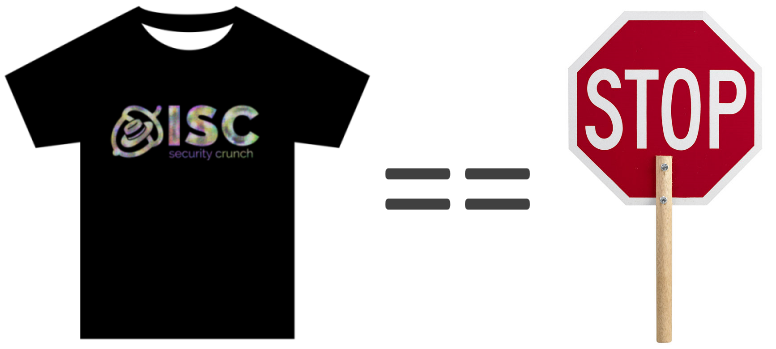


# Fetching Resources

Let's start...

We'll need: 
*    **0.993.dat** : this is the checkpoint of the leaked trained neural network; if our adversarial sample works on this model, it should also work on the model that the car uses
*    **\*GTSRB Test Set** : this is a dataset that contains images of traffic signs which we can use for debugging; we don't actually need it.
*    **isc-mask.png** : this is the ISC's logo which will be 'colored' (just like in the shirt above) so it confuses the neural network

\* *German Traffic Sign Recognition Benchmark (GTSRB)*


I've already handled most of this for you; just solve **[TODO 1]** and **[TODO 2]** and run the code.

In [1]:
# Fetch German Traffic Sign Recognition Benchmark Dataset (Test)
!wget -nc https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget -nc https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip


# TODO[1]: add a command to download http://isc-lab.overfitted.io/static/0.993.dat
# TODO[2]: also download: http://isc-lab.overfitted.io/static/isc-mask.png
!wget -nc http://isc-lab.overfitted.io/static/0.993.dat
!wget -nc http://isc-lab.overfitted.io/static/isc-mask.png


# *sigh*
!unzip GTSRB_Final_Test_Images.zip
!unzip GTSRB_Final_Test_GT.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Final_Test/Images/07634.ppm  
  inflating: GTSRB/Final_Test/Images/07635.ppm  
  inflating: GTSRB/Final_Test/Images/07636.ppm  
  inflating: GTSRB/Final_Test/Images/07637.ppm  
  inflating: GTSRB/Final_Test/Images/07638.ppm  
  inflating: GTSRB/Final_Test/Images/07639.ppm  
  inflating: GTSRB/Final_Test/Images/07640.ppm  
  inflating: GTSRB/Final_Test/Images/07641.ppm  
  inflating: GTSRB/Final_Test/Images/07642.ppm  
  inflating: GTSRB/Final_Test/Images/07643.ppm  
  inflating: GTSRB/Final_Test/Images/07644.ppm  
  inflating: GTSRB/Final_Test/Images/07645.ppm  
  inflating: GTSRB/Final_Test/Images/07646.ppm  
  inflating: GTSRB/Final_Test/Images/07647.ppm  
  inflating: GTSRB/Final_Test/Images/07648.ppm  
  inflating: GTSRB/Final_Test/Images/07649.ppm  
  inflating: GTSRB/Final_Test/Images/07650.ppm  
  inflating: GTSRB/Final_Test/Images/07651.ppm  
  inflating: GTSRB/Final_Test/Images/07652.ppm  
  inflating: GTSRB

# Dataset Loading

This just loads the dataset into a more friendly structure that we can use later. It's not very interesting.

What you'll need from here:
* **ID_TO_LABEL** : this dictionary maps a traffic sign's numeric id (**int**) to its readable (**string**) format; the neural network outputs a number for each recognized traffic sign - so we use this to get its actual description and understand the output.

* **LABEL_TO_ID** : pretty much the inverse of **ID_TO_LABEL**

Luckily no TODOs here; just run the code and continue.

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import pandas as pd
import os
from PIL import Image

ID_TO_LABEL = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

LABEL_TO_ID = {l:c for c,l in ID_TO_LABEL.items()}


class TrafficSignDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_frame = pd.read_csv(csv_file, sep=";")
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels_frame)
    
    def __getitem__(self, idx):
        img = self.labels_frame.iloc[idx]
        image = Image.open(os.path.join(self.root_dir, img['Filename']))
        label = img['ClassId']
        
        if self.transform:
            image = self.transform(image)
        
        sample = [image, label]
        
        return sample

test_dataset_root = 'GTSRB/Final_Test/Images/'
test_image_folder = TrafficSignDataset('GT-final_test.csv', test_dataset_root,
                           transform=transforms.Compose([
                               transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               
                           ]))

test_dataloader = torch.utils.data.DataLoader(test_image_folder, batch_size=1, shuffle=True)


# Model Loading

We don't know the architecture of the network; we need to know its name so we can load the parameters into an object of the corresponding class.

**[TODO 3]**: take a look into **0.993.dat**; can you find the name of the architecture? It should be a pretty popular model.

In [5]:
import torch.nn as nn
import torch

# !unzip 0.993.dat

# [TODO 3]: fill the model's architecture in the variable below
model_name = 'resnet18'
exec('from torchvision.models import ' + model_name)


# this defines the model's overall structure
class TrafficSignClassifier(nn.Module):
  def __init__(self, num_classes=43, affine=True):
      super().__init__()

      exec('self.' + model_name + ' = ' + model_name + '(pretrained=False, norm_layer = nn.InstanceNorm2d, num_classes = num_classes)')

  def forward(self, x):
      x = eval('self.' + model_name + '(x)')

      return x

# this loads the leaked model's parameters
model = TrafficSignClassifier(num_classes = 43)
model.load_state_dict(torch.load('0.993.dat', map_location=torch.device('cpu')))
model.eval()

TrafficSignClassifier(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, mom

# Short Test & Results

This is not part of the "hacking" process. We run a quick test only to see if we loaded the model correctly. 

Once again, in a real attack we pretty much don't have the dataset (and won't need it).

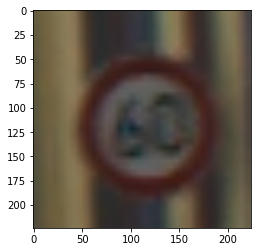

Predicted: 60_speed Expected: 60_speed


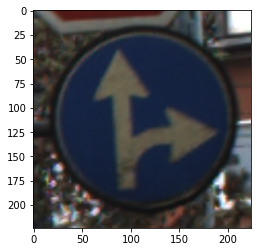

Predicted: turn_straight_right Expected: turn_straight_right


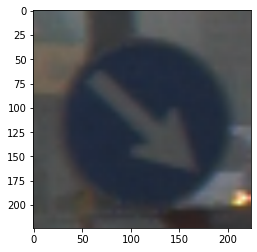

Predicted: turn_right_down Expected: turn_right_down


In [6]:
import matplotlib.pyplot as plt
import cv2

# this is added so we won't run & display the entire dataset here
IMG_LIMIT = 3

# iterate through the GTSRB test dataset
# X_test : image (actually tensor) which contains a traffic sign
# y_test : array (actually still a tensor) which  
for batch_id, (X_test, y_test) in enumerate(test_dataloader):
  # stop if too many images were shown
  if batch_id + 1 > IMG_LIMIT:
    break

  # y_pred : an array (tensor) which contains probabilities for each known traffic sign
  y_pred = model(X_test).detach()

  # this converts the tensor to an image so we can display it
  X_imgs = [img.permute(1, 2, 0).numpy() for img in X_test]

  # from the prediction, we take the index (id) of the traffic sign that has the highest probability
  y_pred = torch.argmax(y_pred, dim=1)

  # we show some results and see if this is working
  for i in range(len(X_imgs)):
    plt.imshow(X_imgs[i])
    plt.show()
    cv2.imwrite(str(i) + '.png', cv2.cvtColor(X_imgs[i] * 255, cv2.COLOR_RGB2BGR))
    print('Predicted:', ID_TO_LABEL[y_pred[i].item()], 'Expected:', ID_TO_LABEL[y_test[i].item()]) 

# Generating Adversarial Samples

Now let's move to the interesting part: creating adversarial samples. The PyTorch framework will do the low-level math for you automatically - don't worry about that :)

## Steps

1.   Generate a **random image** with 3 channels (Red, Green, Blue); think of this image as a matrix made of *NUM_CHANNELS x WIDTH x HEIGHT* parameters -> these parameters will be tuned to generate a specific output in the neural network

2.   Run the image through the **neural network** and it will tell you the **probabilities** of it being any of the **known traffic signs**.

3.   Use the outputted **probabilities** to calculate the **error / loss**; this error is backpropagated to your image by PyTorch's autodifferentiation module (so you don't have to do the fancy math).

4.   Adjust the values of the pixels in the inverse direction of the received feedback (gradients). Once again, this is done by PyTorch.

5.   Go back to step 2 and repeat.

**[TODO 4]** requires you to specify the **shape** of the image; a shape says how many dimensions your structure (tensor) has. 
E.g., the shape (2, 2) describes an array with 2 rows and 2 columns.

For **[TODO 5]** you'll have to pick a **learning rate** - there's no "correct" answer here, just see what works for you.

In **[TODO 6]** you'll have to specify which traffic sign you're targeting -- and in **[TODO 7]** you have to set the number of iterations (epochs).

----
*At this point...* if you solved the TODOs the algorithm should generate and draw **noisy images** that are classified as the traffic sign you targeted.

## Applying the Mask

For **[TODO 8]** you have to use the ISC mask when generating images. However, you'll notice that the algorithm is coloring the background and not the logo. For the last task (**[TODO 9]**) you'll have to invert the mask so the background stays black and the logo is colored.

In [10]:
import cv2

# [TODO 4]: pick a shape for the adversarial sample
# it should have 1 batch, 3 channels, 224px pixels in height and 224px in width
adversarial_sample_shape = (1, 3, 224, 224)
adversarial_sample = torch.rand(adversarial_sample_shape)

# enable gradient-based optimizations for this tensor
adversarial_sample.requires_grad_()

# [TODO 5] pick a learning rate (lr); try not to go over 1 or too close to 0
adversarial_lr = 0.2
adversarial_optimizer = torch.optim.Adam([adversarial_sample], lr=adversarial_lr)

# [TODO 6]: pick a targeted adversarial class (remember the 2 dictionaries at the beginning?)
targeted_traffic_sign_id = 14
targeted_adversarial_class = torch.LongTensor([targeted_traffic_sign_id])

# using CrossEntropy loss in this scenario
adversarial_criterion = torch.nn.CrossEntropyLoss()

# loading the ISC mask 
mask_path = 'isc-mask.png'
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# tensor conversion
mask = torch.FloatTensor(mask).unsqueeze(0).unsqueeze(0) / 255

# [TODO 8]: use the ISC mask as current mask
crt_mask = mask

# [TODO 9]: find a way to invert the mask so instead of coloring the background, the algorithm colors the foreground (logo)
# PS: python supports basic numeric opperations between scalars and tensors / matrices; you don't have to use loops or complex code
crt_mask = 1 - mask;

# [TODO 7]: define a number of epochs; start small and see what works for you
num_epochs = 100

for i in range(num_epochs):
  adversarial_optimizer.zero_grad()

  crt_input = torch.sigmoid(adversarial_sample)

  if crt_mask is not None:
    crt_input = torch.sigmoid(adversarial_sample) * crt_mask

  y_pred = model(crt_input + 0.2 * (torch.rand_like(crt_input) * 2 - 1))

  loss = adversarial_criterion(y_pred, targeted_adversarial_class)

  adversarial_img = crt_input.detach().permute(0, 2, 3, 1)[0].numpy()

  plt.imshow(adversarial_img)
  plt.show()


  y_conf = torch.max(torch.softmax(y_pred, dim = 1), dim = 1)[0].item()
  y_pred = torch.argmax(y_pred, dim=1)[0].item()
  print('Predicted:', ID_TO_LABEL[y_pred], 'Adversarial loss:', loss.item(), 'Confidence:', y_conf * 100, '%')

  loss.backward()

  adversarial_optimizer.step()

Output hidden; open in https://colab.research.google.com to view.

# You made it!!

This is the end of this laboratory - it's still in beta so any feedback is welcome.

### Submission and Evaluation

Just download your **image** from colab and upload it on **curs.upb.ro** on the **assignment** made for this laboratory. You can easily download that file from the *Files* section in colab (the menu on the left). 

It will be verified using a checker that implements the same neural network.

### Conditions

* the resulted stylized image (with the ISC logo) must achive **over 80% (0.8) confidence** to be considered valid
* the background must remain black and only the foreground should get colored - just like in the shirt or demo

### Checker

You can use http://isc-lab.overfitted.io to upload your image and see the results (from your web browser). 

There's also this small API:




In [11]:
import requests

final_img = crt_input.detach().permute(0, 2, 3, 1)[0].numpy() * 255
final_img = cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR)

cv2.imwrite('adversarial_sample.png', final_img)

files = {'img': open('adversarial_sample.png','rb')}
r = requests.post('http://isc-lab.overfitted.io/checker', files=files)

print(r.text)

{"label": "stop", "confidence": 0.9820813536643982}
